<h1>Extract Avulsion Site Slope and Plot Long Profiles</h1>

This notebook plots SRTM surface models for each river, corresponding channel networks and avulsion locations
to measure the distance upstream an avulsion site + calculate local slope

<h2> Method </h2>

Slopes are measured over 5km , which are then binned into 25 km non-overlapping windows. The median and IQR of the 5 slopes within a chosen window are then used as representative.

In [1]:
__author__ = "Sam Brooke"
__email__ = "sbrooke@ucsb.edu"

import os
import csv
import glob
import fiona
import rasterio
import rasterio.plot as rp
import numpy as np
import matplotlib as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy import stats, signal
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint, Point
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

srtm_dsms = './elevation_data/srtm_30m/'
channel_iqr_profiles = './profiles'
channel_planforms = './trunk_streams/'

slope_window_m = 25000 # Every 25 km bin the slopes

output_dir = './elevation_data'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)


def hillshade(delta, axes):
    with rasterio.open(delta) as d:
        dem = d.read(1)
        dem = dem.astype(rasterio.float32)
        dem[dem==0] = np.nan
        cmap = plt.cm.twilight_shifted
        scalebar = ScaleBar(d.transform[0]/22) # 1 pixel = 0.2 meter
        axes.add_artist(scalebar)
        rp.show(dem, ax=axes, cmap=cmap, transform=d.transform)


def raster_values(x_list,y_list, start_x, start_y, band,affine, start_reference=True):
    # This function extracts data from a geotiff based on coordinates
    
    # Check beginning and last nodes to get the correct ordering
    d_start = math.hypot(start_x - x_list[0], start_y - y_list[0])
    d_end = math.hypot(start_x - x_list[-1], start_y - y_list[-1])
        
    if d_start > d_end:
        x_list = list(x_list)
        y_list = list(y_list)
        x_list.reverse()
        y_list.reverse()
        
    row, col = ~affine * (np.array(x_list), np.array(y_list)) # x, y to raster coords
    
    dims = band.shape
    
    coord_distances = []
    rasters_vals = []
    
    for x, y in zip(row, col):
        
        c = x.astype(int)
        r = y.astype(int)
        
        #if c < dims[0] and r < dims[1]:
            
        rasters_vals.append(band[r,c])
    
    
    cumulative_distance = []
    
    for n, x in enumerate(x_list):
        if n == 0:
            if start_reference:
                cumulative_distance.append(math.hypot(start_x - x, start_y - y_list[n]))
            else:
                cumulative_distance.append(0)
        else:
            cumulative_distance.append(cumulative_distance[n-1]+(math.hypot(x_list[n-1] - x, y_list[n-1] - y_list[n])))

    return rasters_vals, cumulative_distance, x_list, y_list


def get_closest_value(arr, target):

    n = len(arr)
    left = 0
    right = n - 1
    mid = 0

    # edge case - last or above all
    if target >= arr[n - 1]:
        return arr[n - 1]
    # edge case - first or below all
    if target <= arr[0]:
        return arr[0]
    # BSearch solution: Time & Space: Log(N)

    while left < right:
        mid = (left + right) // 2  # find the mid
        if target < arr[mid]:
            right = mid
        elif target > arr[mid]:
            left = mid + 1
        else:
            return arr[mid]

    if target < arr[mid]:
        return find_closest(arr[mid - 1], arr[mid], target)
    else:
        return find_closest(arr[mid], arr[mid + 1], target)


# findClosest
# We find the closest by taking the difference
# between the target and both values. It assumes
# that val2 is greater than val1 and target lies
# between these two. 
def find_closest(val1, val2, target):
    return val2 if target - val1 >= val2 - target else val1

def get_local_slope(x, y, interp=50, window=1000):
    
    # Collect local slopes within desired window
    
    new_x = list(range(int(min(x))+1, int(max(x))-1, interp))
    f = interp1d(x, y)
    new_y = f(new_x)
    
    slope_x = []
    slopes = []
    
    x_in_range = True
    x_target = min(new_x)
    
    while x_in_range is True:
        
        x_target +=window
        
        if x_target < max(new_x):
            
            start_val = get_closest_value(new_x, x_target-window) # Get closet x to our target x - window len
            nearest_next_val = get_closest_value(new_x, x_target)
            start_idx = new_x.index(start_val)
            end_idx = new_x.index(nearest_next_val)
            query_d = new_x[start_idx:end_idx]
            mid_x = int((end_idx-start_idx)/2)
            query_z = new_y[start_idx:end_idx]
            
            rise = query_z[-1]-query_z[0]
            run = query_d[-1]-query_d[0]
            slope = rise/run
#             slope, intercept, r_value, p_value, std_err = stats.linregress(query_d,query_z)
            slopes.append(slope)
            slope_x.append(query_d[mid_x])
            
        else:
            x_in_range = False
    
    return slope_x, slopes

def get_slope_windows(delta_name, slope_binned, av_idx):
    
    down_wins = slope_windows[delta_name][0]
    up_wins = slope_windows[delta_name][1]
    
    downstream_idxs = False
    upstream_idxs = False
    
    upstream_idxs = list(range(av_idx+up_wins[0],av_idx+up_wins[1]))
    upstream_slopes = slope_binned.iloc[upstream_idxs]
    downstream_slopes = slope_binned.iloc[av_idx]
    downstream_idxs = [av_idx]

    return upstream_slopes, downstream_slopes, upstream_idxs, downstream_idxs

In [2]:
# Plot the long profile and local slope for each river as subplots

rivers_all = ['mangoky', 'betsiboka', 'mahajamba', 'manambolo', 'morondava', 'sambao', 'fiherenana']
rivers = ['betsiboka', 'mahajamba', 'manambolo', 'morondava', 'sambao', 'fiherenana']

alpha = ['a', 'b', 'c', 'd', 'e', 'f']

# LA
avulsion_distances_static = { 
    'betsiboka': 169137.705,
    'fiherenana': 5238.988,
    'mahajamba': 198778.527,
    'manambolo': 22648.716,
    'morondava': 38213.48,
    'sambao': 30454.987,
    'mangoky': 55754.555
}

# Plotting x limits
min_max_distances_km = {
    'betsiboka': [50, 250],
    'fiherenana': [0, 30],
    'mahajamba': [100, 300],
    'manambolo': [0, 60],
    'morondava': [0, 80],
    'sambao': [20, 70],
    'mangoky': [0, 100]
}

# Plotting y limits
min_max_elevations_m = {
    'betsiboka': [0, 500],
    'fiherenana': [-5, 100],
    'mahajamba': [0, 500],
    'manambolo': [-5, 100],
    'morondava': [-5, 200],
    'sambao': [0, 100],
    'mangoky': [0, 200]
}

# Plotting x intervals
xtick_intervals_elevations_km = {
    'betsiboka': 50,
    'fiherenana': 10,
    'mahajamba': 50,
    'manambolo': 10,
    'morondava': 10,
    'sambao': 10,
    'mangoky': 50
}

# Plotting y intervals
y_ticks_m = {
    'betsiboka': [0, 100, 200, 300, 400, 500],
    'fiherenana': [0, 20, 40, 60, 80, 100],
    'mahajamba': [0, 100, 200, 300, 400, 500],
    'manambolo': [0, 20, 40, 60, 80, 100],
    'morondava': [0, 50, 100, 150, 200],
    'sambao': [0, 20, 40, 60, 80, 100],
    'mangoky': [0, 50, 100, 150, 200]
}

reverse_needed = { # Depends on whether river centerline was drawn upstream or downstream, oops
    'betsiboka': True,
    'fiherenana': False,
    'mahajamba': True,
    'manambolo': False,
    'morondava': True,
    'sambao': True,
    'mangoky':True
}

avulsion_type = {
    'betsiboka': 'inland',
    'fiherenana': 'delta',
    'mahajamba': 'inland',
    'manambolo': 'delta',
    'morondava': 'delta',
    'sambao': 'delta',
    'mangoky': 'delta'
}

river_axes = { # For the 3x3 A4 plot
    'betsiboka': [0,0],
    'fiherenana': [0,2], 
    'mahajamba': [0,1],
    'manambolo': [1,0],
    'morondava': [1,1],
    'sambao': [1,2]
}

# Savitzky-Golay filter windows (metres)
smoothing_windows = {
    'betsiboka': 251,
    'fiherenana': 251,
    'mahajamba': 251,
    'manambolo': 251,
    'morondava': 251,
    'sambao': 251,
    'mangoky': 251
}


# Selection of windows for representative upstream/downstream slopes
slope_windows = {
    'betsiboka': [[0,0],[1,2]], # Slope window indexes
    'fiherenana': [[0,0],[1,2]],
    'mahajamba': [[0,0],[2,3]],
    'manambolo': [[0,0],[1,2]],
    'morondava': [[0,0],[1,2]],
    'sambao': [[0,0],[1,2]],
    'mangoky': [[0,0],[1,2]]
}


# Figure plot dimensions
fig_width_cm = 25.7                              # A4 page
fig_height_cm = 13
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width+2, fig_height+1]

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 
    
    
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(fig_size)
gspec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

color = 'black'

for idx, riv in enumerate(rivers):
        
    # Read IQR profiles
    elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, riv+'_profile.csv'))
    elev_data = elev_data[elev_data['median'] <= 5000] # Remove invalid data (nodata is usually a high int)
    elev_data = elev_data[elev_data['stdev'] <= 20] # Any data with a stdev greater than 20 is spurious
    elev_data.reset_index(drop=True)

    if reverse_needed[riv]:
        elev_data['distance'] = abs(elev_data['distance']-(np.max(elev_data['distance'])))
    
    # Get plotting limits from dicts
    max_height = min_max_elevations_m[riv][1]
    min_height = min_max_elevations_m[riv][0]
    max_dist_m = min_max_distances_km[riv][1]*1000
    min_dist_m = min_max_distances_km[riv][0]*1000
    max_dist_km = min_max_distances_km[riv][1]
    min_dist_km = min_max_distances_km[riv][0]
    
    local_slope = [] # Where we'll store the local slopes per window
    central_distances = [] # Mid-window distances

    distance_km = [x / 1000 for x in elev_data['distance']] # convert to km    
    av_dist = avulsion_distances_static[riv] # avulsion distance [m]
    
    # What's the idx of the start of the river?
    if min_dist_km == 0:
        if reverse_needed[riv]:
            min_dist_idx = -1
        else:
            min_dist_idx = 0
    else:
        min_dist_idx = distance_km.index(min_dist_km)

    max_dist_idx = distance_km.index(max_dist_km)
    
    # Remove some of the roughness of the river using Savitsky-Golay filter
    if reverse_needed[riv]:
        smoothed_elevation = signal.savgol_filter(elev_data['median'], smoothing_windows[riv], 1)
    else:
        smoothed_elevation = signal.savgol_filter(elev_data['median'], smoothing_windows[riv], 1)
    
    # River profile axes
    rx = river_axes[riv]
    ax = fig.add_subplot(gspec[rx[0], rx[1]])
    axb = ax.twinx()  # instantiate a second axes that shares the same x-axis
    
    # Get local slope every 5000 metres
    slope_x, slopes = get_local_slope(elev_data['distance'], smoothed_elevation, window=5000) # Per m
    # Put into a dataframe
    slope_df = pd.DataFrame(list(zip(slope_x, slopes)), columns = ['x', 'slope'])
    slope_df = slope_df[slope_df['slope'] > 0] # Remove invalid data
    slope_df.reset_index(drop=True)
    
    # Plot local slope on profile axis
#   axb.scatter(slope_df['x'], slope_df['slope'], 10, color='darkred', zorder=7, alpha=0.5)

    max_dist = slope_df.x.max()

    # Group slope values into windows bins
    wr = np.arange(0, max_dist+slope_window_m, slope_window_m)
    slope_window_groups = slope_df.groupby(pd.cut(slope_df["x"], wr))
    slope_binned = slope_window_groups.median() # Median slope for every window
    ds = slope_window_groups.std() # Slope error per window
    quart_25 = slope_window_groups.quantile(q=0.25) # 25th pctile per window
    quart_75 = slope_window_groups.quantile(q=0.75) # 75th pctile per window

    # Add columns to slope_binned to create single dataframe
    slope_binned['std'] = list(ds.slope)
    slope_binned['pct_25'] = list(quart_25.slope)
    slope_binned['pct_75'] = list(quart_75.slope)
    slope_binned['idx'] = np.arange(len(slope_binned))

    intervals = slope_binned.index.tolist()
    slope_binned.index = range(0,len(list(ds.slope)))
    slope_binned.reset_index()

    # Avulsion distance upstream
    con_d = avulsion_distances_static[riv]                                 
    av_idx = abs(slope_binned['x'] - con_d).idxmin() # Which bin is our avulsion in?
    bin_idx = int(slope_binned.loc[av_idx]['idx']) # Index of bin that avulsion is on

    upstream_slopes, downstream_slopes, ups_idxs, dns_idxs = get_slope_windows(riv, slope_binned, av_idx)  

    slope_neg_error = []
    slope_pos_error = []
    slope_val = []
    slope_center = []
    
    # Draw windows on slope axes
    for index, row in slope_binned.iterrows():
        
        intv = intervals[index]
        b_left = intv.left
        b_right = intv.right
        b_bottom = float(row['pct_25'])
        b_top = float(row['pct_75'])
        b_width = b_right-b_left
        b_height = b_top-b_bottom
                
        slope_val.append(float(row['slope'])) # median slope value
        slope_neg_error.append(row['slope']-b_bottom)
        slope_pos_error.append(b_top-row['slope'])
        slope_center.append((b_left+b_right)/2)
        
        fcolor = 'lightcoral'
        
        # [Optional] change colour depending on whether we are using window for representative local slopes
#         if row['idx'] in ups_idxs:
#             fcolor = 'lightgreen'
#         elif row['idx'] in dns_idxs:
#             fcolor = 'yellow'
    
        # Create rectangle patch
        rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                 edgecolor=fcolor,facecolor=fcolor, 
                                 fill=True, alpha=0.5)
        axb.add_patch(rect)
    
    # Find index of avulsion node
    av_idx = abs(elev_data['distance'] - av_dist).idxmin()
    av_elev = elev_data['median'][av_idx] # avulsion elevation
    
#     ax.fill_between(elev_data['distance'], pos_error, neg_error, facecolor='blue', alpha=0.5)

    # Plot elevation profile as smooth black line
    ax.plot(elev_data['distance'], smoothed_elevation, color='black', zorder=0)
    
#     axb.errorbar(slope_center, slope_val, yerr=[slope_neg_error, slope_pos_error], 
#                  fmt='o', color='darkred', ecolor='black', elinewidth=0.5)

    # Plot median local slope in the centre of the windows as a red dot
    axb.scatter(slope_center, slope_val,  s=50, facecolors='darkred',zorder=10)    
    
    # Colour based on avulsion type
    if avulsion_type[riv] == 'delta':
        av_color = 'yellow'
    else:
        av_color = 'tab:cyan'
    
    # Add avulsion location as a star
    ax.scatter(av_dist, av_elev, s=300, marker=(5, 1), facecolors=av_color, edgecolors=(0, 0, 0), zorder=15)

    ax.set_ylabel('Elevation [m]', color='black')
    ax.set_xlabel('Distance upstream of shoreline [km]')
    ax.set_ylim(min_height, max_height)
    
    xticks = range(min_dist_m, max_dist_m+xtick_intervals_elevations_km[riv]*1000, xtick_intervals_elevations_km[riv]*1000)
    ax.set_xticks(xticks)
    ax.set_xticklabels(map(lambda x: str(int(x)), np.array(xticks, dtype=np.uint32)/1000))
    
    axb.tick_params(axis='y', colors='tab:red')
                    
    ax.yaxis.set(ticks=y_ticks_m[riv])
    plt.text(0.05, 0.95,alpha[idx]+') '+riv.capitalize(), ha='left', va='top', transform=ax.transAxes, fontsize=12)
    
    
    color = 'tab:red'
    axb.set_ylim(0, 0.01)
    axb.set_ylabel('Topographic slope [-]', color=color)
    axb.yaxis.set(ticks=[0, 0.002, 0.004, 0.006, 0.008, 0.01])
    axb.set_xlim(min_dist_m, max_dist_m)
    
    axb.spines['right'].set_color('tab:red')
    axb.tick_params(axis='y', colors='tab:red')

if not os.path.isdir('figures'):
    os.makedirs('figures')

# Plot and save
plt.tight_layout()
plt.savefig('figures/profiles.pdf', dpi=300, orientation='landscape', transparent=True)


<ipython-input-2-5be6f7ca91f4>:308: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


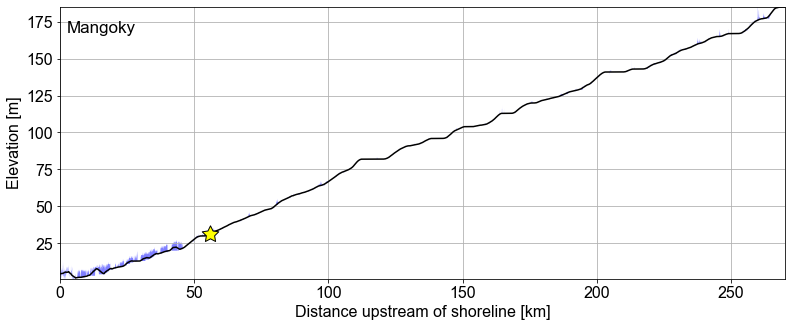

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


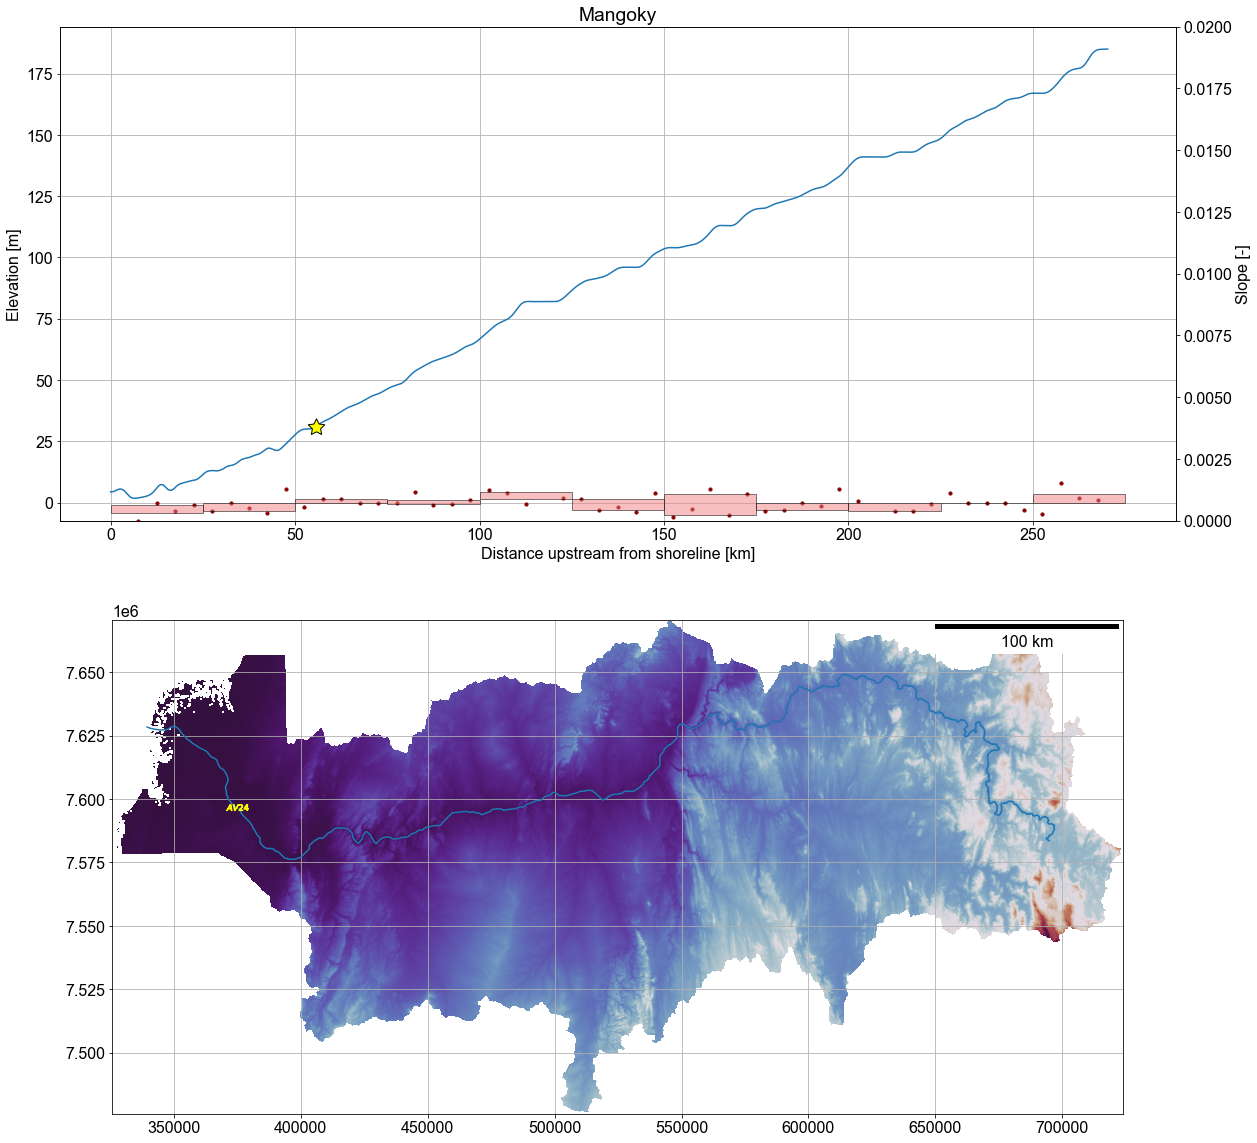

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


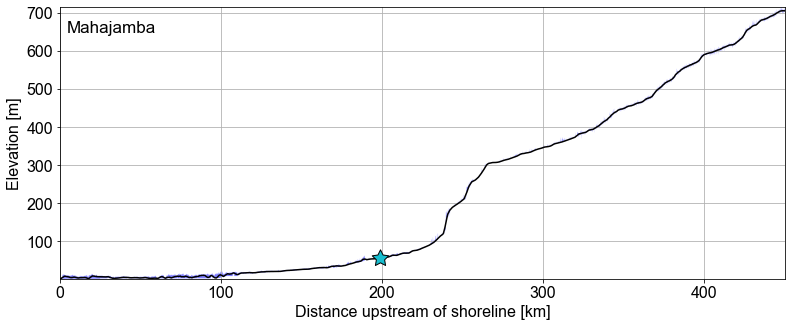

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


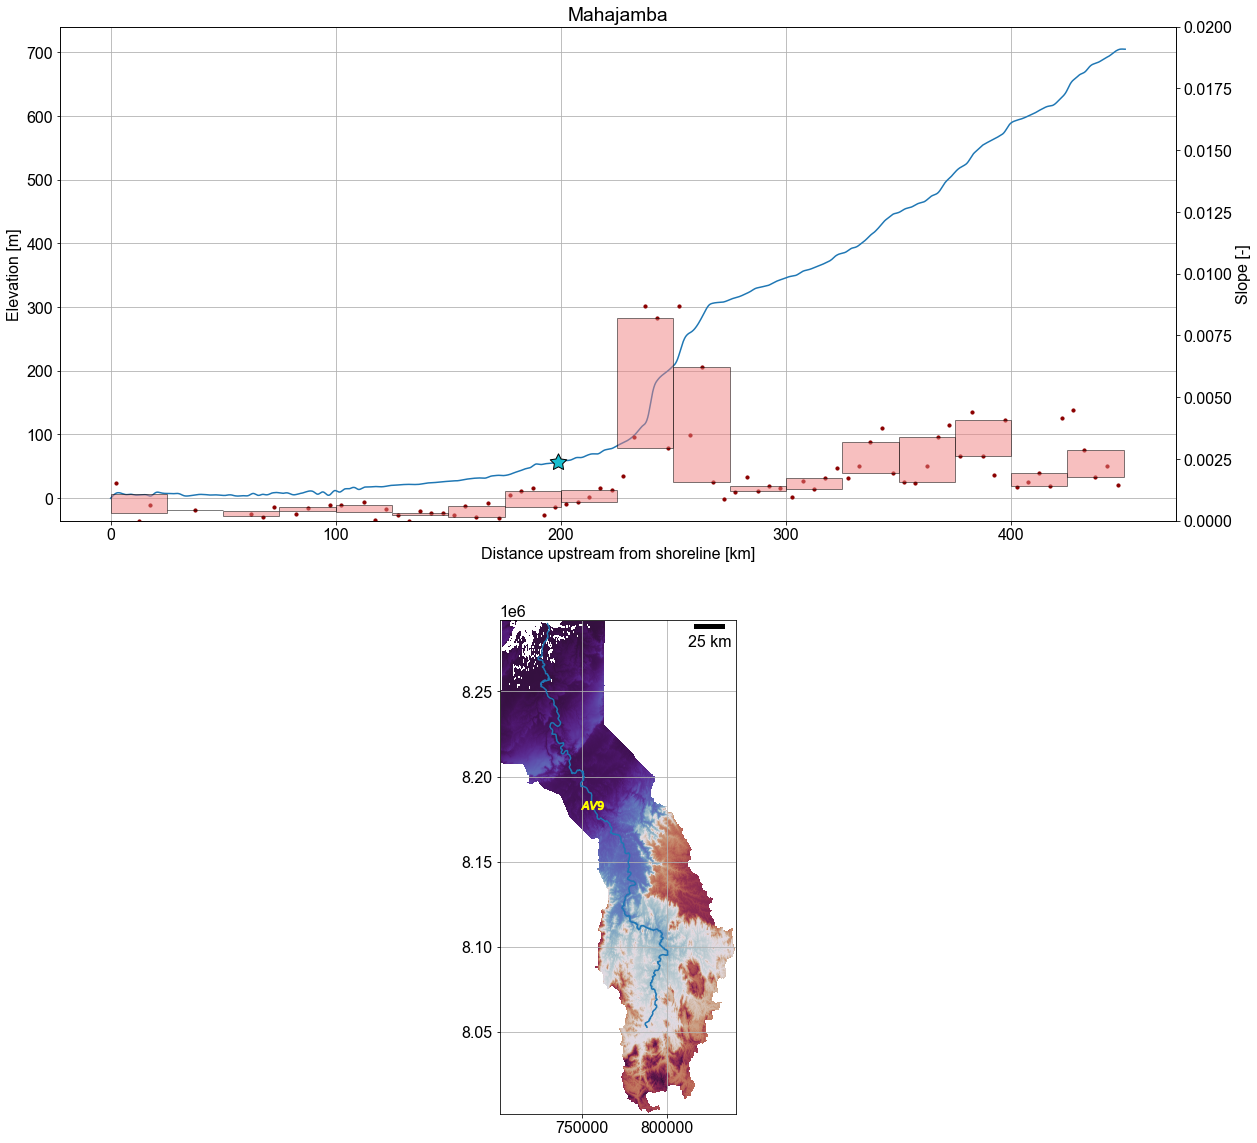

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


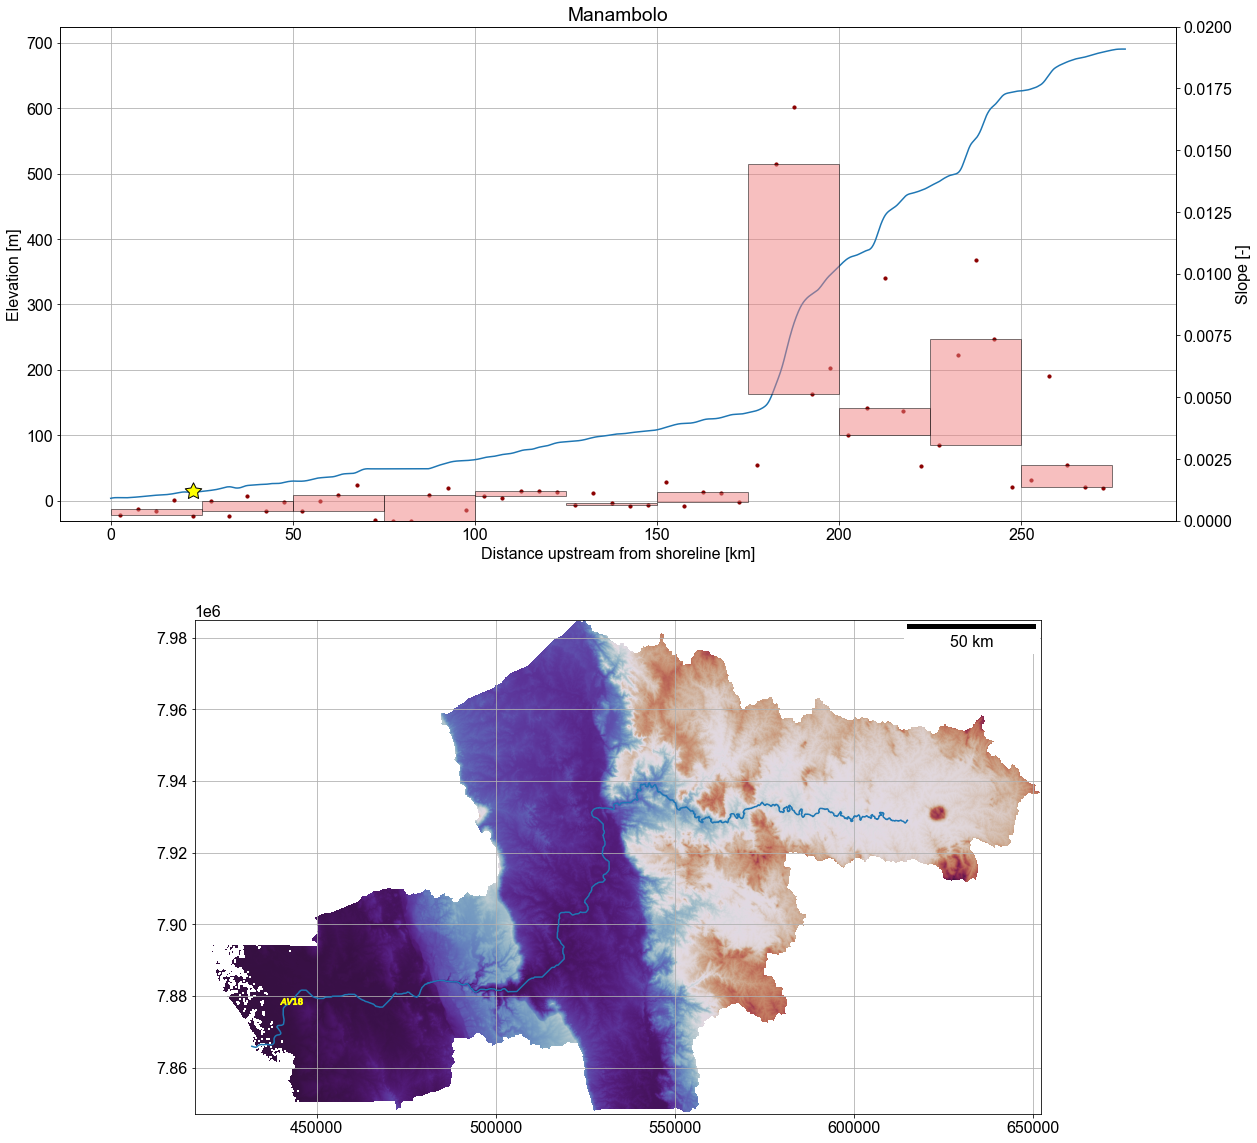

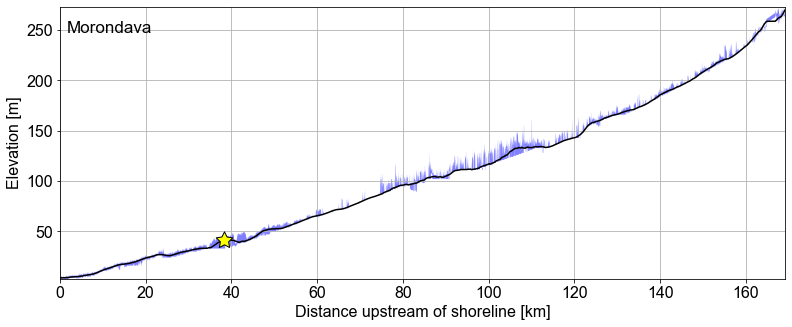

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


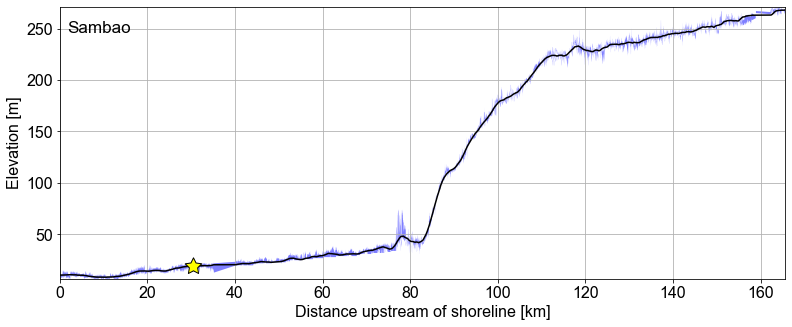

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


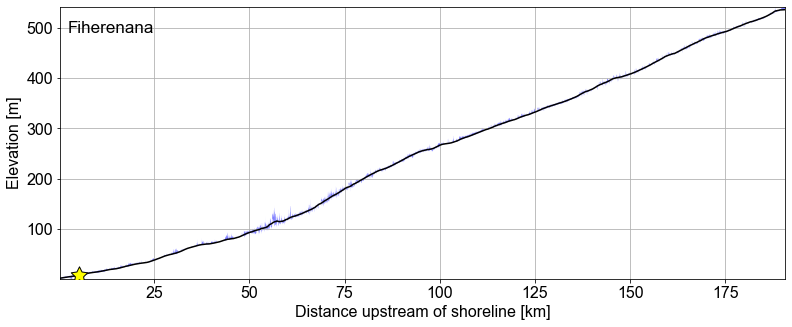

<ipython-input-3-1efd3e10458e>:264: UserWarning: FixedFormatter should only be used together with FixedLocator
  profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))


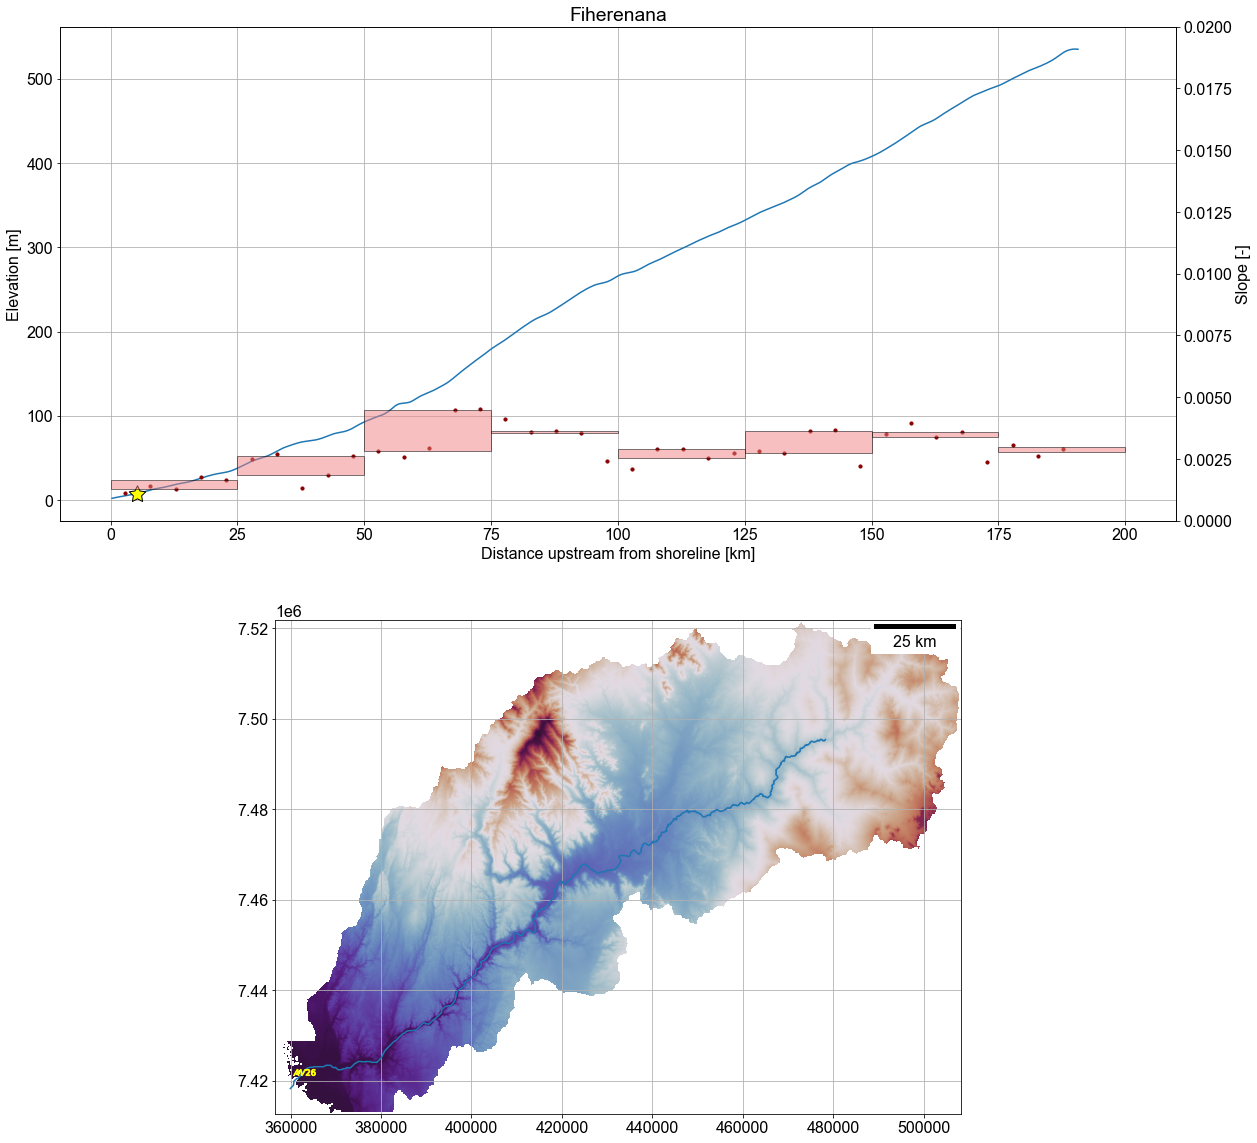

In [3]:
# Plot the surface model and individual long profiles and local slopes
# Also export the upstream and downstream slopes per avulsion

from IPython.display import IFrame, display, HTML
import matplotlib.patches as patches
import matplotlib
import time

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print HTML to notebook
def display_html_inline(html):
    display(HTML(html, metadata=dict(isolated=True)))

font = {'family' : 'arial',
        'size'   : 16}

mpl.rc('font', **font)

slope_windows = { # How many slope windows to query upstream and downstream to capture slope breaks
    'betsiboka': [[0,0],[1,2]],
    'fiherenana': [[0,0],[1,2]],
    'mahajamba': [[0,0],[2,3]],
    'manambolo': [[0,0],[1,2]],
    'morondava': [[0,0],[1,2]],
    'sambao': [[0,0],[1,2]],
    'mangoky': [[0,0],[1,2]]
}

slope_window_m = 25000

output_details = os.path.join(output_dir, 'avulsion_slope_details.csv')


def plot_delta(delta_name, elev_data):
    
    # This function plots the windows and elevations as well as the planform river course 
    # on a hillshaded SRTM backdrop
    
    if delta_name == 'mahajamba': # Use 1999 river course for Mahajamba
        srtm = os.path.join(srtm_dsms, 'mahajamba.tif')
        delta_name_avulsions = ['mahajamba', 'Mahajamba_1999']
        channel = os.path.join(channel_planforms, 'Mahajamba_1999.shp')
    else:
        srtm = os.path.join(srtm_dsms, delta_name+'.tif')
        delta_name_avulsions = [delta_name, delta_name.capitalize()]
        channel = os.path.join(channel_planforms, delta_name.capitalize()+'.shp')
        
    avulsion_nodes = './avulsion_locations/avulsion_db_utm32738.shp' # In UTM so we can use metres
    channel_start_nodes = './avulsion_locations/river_start_nodes.shp' # Mapped nodes where rivers begin

    fig2, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

    profile_axes = axes[0]
    map_axes = axes[1]
    slope_axes = profile_axes.twinx()  # instantiate a second axes that shares the same x-axis
    
    hillshade(srtm, map_axes) # Make hillshade map
    
    # Write slope data to csv
    with open(output_details, 'a', newline="\n") as av_detail:

        avulsion_writer = csv.writer(av_detail, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)

        with rasterio.open(srtm) as srtm_src: # Open SRTM raster

            with fiona.open(avulsion_nodes) as av: # Open avulsion node points

                with fiona.open(channel) as ch: # Open channel path 

                    with fiona.open(channel_start_nodes) as sn: # Open start nodes

                        start_node = False

                        for node in sn:
                            if node['properties']['River'] in delta_name_avulsions:
                                start_node = node['geometry']['coordinates']
                            else:
                                continue;

                        reaches = []
                        distance_from_start_node = []

                        for reach in ch:

                            if reach['geometry']: # For each river reach (usually one trunk stream)

                                if len(reach['geometry']['coordinates']) > 100:

                                    map_axes.plot(*zip(*reach['geometry']['coordinates'])) # Plot river planform path
                                    x, y = zip(*reach['geometry']['coordinates'])

                                    # Get elevations and distances from SRTM
                                    elevs, dists, x_sorted, y_sorted = raster_values(x,y,start_node[0], start_node[1], 
                                                                 srtm_src.read(1), srtm_src.transform, start_reference=False)

                                    # Create dataframe (x, y (coords), z (elevation), and d (distance))
                                    df = pd.DataFrame(list(zip(x_sorted, y_sorted, elevs, dists)), 
                                                   columns =['x', 'y', 'z', 'd']) 
                                    
                                    # Convert to geopandas dataframe
                                    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

                                    reaches.append(gdf)
                                    
                                    # Distances relative to the location of the river mouth
                                    distance_from_start_node.append(math.hypot(start_node[0] - x_sorted[0], start_node[1] - y_sorted[0]))
                        
                        # Find the nearest point the tributaries are on the main trunk and what distance they join

                        trunk_idx = distance_from_start_node.index(min(distance_from_start_node)) # Trunk river reach
                        trunk_river = reaches[trunk_idx]

                        def nearest(point, gpd2_pts, gpd2, geom_col='geometry', distance_col = 'd'):
                            # find the nearest point along river
                            nearest_point = nearest_points(point, gpd2_pts)[1]
                            # return the corresponding value of the src_col of the nearest point
                            
                            distance = float(gpd2[gpd2[geom_col] == nearest_point][distance_col])
                            con_x = float(gpd2[gpd2[geom_col] == nearest_point]['x'])
                            con_y = float(gpd2[gpd2[geom_col] == nearest_point]['y'])

                            if 'trib' in gpd2.columns:
                                con_t = float(gpd2[gpd2[geom_col] == nearest_point]['trib'])
                            else:
                                con_t = 0

                            return con_x, con_y, distance, con_t

                        gpd2_pts_list = trunk_river.geometry.tolist()
                        gpd2_pts = MultiPoint(gpd2_pts_list) # Trunk river multipoint geometry
                        
                        # Get local slope of trunk stream and save data to files

                        if os.path.exists(os.path.join(output_dir, delta_name+'_local_slope.csv')):
                            os.remove(os.path.join(output_dir, delta_name+'_local_slope.csv'))

                        if os.path.exists(os.path.join(output_dir, delta_name+'_long_profile.csv')):
                            os.remove(os.path.join(output_dir, delta_name+'_long_profile.csv'))

                        with open(os.path.join(output_dir, delta_name+'_local_slope.csv'), 'w+', newline="\n") as slopefile:

                            slope_writer = csv.writer(slopefile, delimiter=',',
                                                    quotechar='|', quoting=csv.QUOTE_MINIMAL)
                            slope_writer.writerow(['distance_m', 'slope_gradient', 'reach'])

                            with open(os.path.join(output_dir, delta_name+'_long_profile.csv'), 'w+', newline="\n") as deltafile:

                                lp_writer = csv.writer(deltafile, delimiter=',',
                                                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
                                lp_writer.writerow(['distance_m', 'elevation_m', 'reach'])
                                
                                # Create d_trib to contain the cumulative distances
                                for ridx, r in enumerate(reaches):

                                    if ridx != trunk_idx:
                                        r2 = r.loc[r['d'].idxmin()]
                                        con_x, con_y, con_d, con_t = nearest(r2.geometry, gpd2_pts, gpd2=trunk_river)
                                        r['d_cumul'] = r['d'] + con_d
                                        r['trib'] = ridx
                                        reaches[ridx] = r
                                    else:
                                        r['d_cumul'] = r['d']
                                        r['trib'] = ridx
                                        reaches[ridx] = r
                                
                                # Elevation along the trunk stream
                                trunk_dist = elev_data['distance']
                                trunk_elev = elev_data['sgolay']
                                
                                # Savgol Filter over resampled profile
                                new_x = list(range(int(min(trunk_dist))+1, int(max(trunk_dist))-1, 30))
                                f = interp1d(trunk_dist, trunk_elev)
                                window_size, poly_order = 151, 3
                                smoothed_profile = savgol_filter(f(new_x), window_size, poly_order)
                                
                                # Get local slope every 5000 metres
                                slope_x, slopes = get_local_slope(new_x, smoothed_profile, window=5000) # Per m
                                # Put into a dataframe
                                slope_df = pd.DataFrame(list(zip(slope_x, slopes)), columns = ['x', 'slope'])
                                slope_df = slope_df[slope_df['slope'] > 0] # Remove invalid data
                                slope_df.reset_index(drop=True)
                                
                                # Plot local slope on profile axis
                                slope_axes.scatter(slope_df['x'], slope_df['slope'], 10, color='darkred')
                                
                                max_dist = slope_df.x.max()
                                
                                # Group slope values into windows bins
                                wr = np.arange(0, max_dist+slope_window_m, slope_window_m)
                                slope_window_groups = slope_df.groupby(pd.cut(slope_df["x"], wr))
                                slope_binned = slope_window_groups.median() # Median slope for every window
                                ds = slope_window_groups.std() # Slope error per window
                                quart_25 = slope_window_groups.quantile(q=0.25) # 25th pctile per window
                                quart_75 = slope_window_groups.quantile(q=0.75) # 75th pctile per window
                                
                                # Add columns to slope_binned to create single dataframe
                                slope_binned['std'] = list(ds.slope)
                                slope_binned['pct_25'] = list(quart_25.slope)
                                slope_binned['pct_75'] = list(quart_75.slope)
                                slope_binned['idx'] = np.arange(len(slope_binned))
                                

                                down_wins = slope_windows[delta_name][0] # Windows to select downstream of avulsion
                                up_wins = slope_windows[delta_name][1] # Windows to select upstream of avulsion
                                
                                # Reset the window-binned slope index so they are incrementing in the 
                                # correct direction
                                
                                intervals = slope_binned.index.tolist()
                                slope_binned.index = range(0,len(list(ds.slope)))
                                slope_binned.reset_index()
                                
                                # Avulsion distance upstream
                                con_d = avulsion_distances_static[delta_name]                                
                                av_idx = abs(slope_binned['x'] - con_d).idxmin() # Which bin is our avulsion in?
                                bin_idx = int(slope_binned.loc[av_idx]['idx']) # Index of bin that avulsion is on

                                upstream_slopes, downstream_slopes, ups_idxs, dns_idxs = get_slope_windows(delta_name, slope_binned, av_idx)  
                                
                                # Draw windows on slope axes and colour according to whether
                                # they have been chosen for representative upstream slope (green)
                                for index, row in slope_binned.iterrows():
                                        
                                    intv = intervals[index]
                                    b_left = intv.left
                                    b_right = intv.right
                                    b_bottom = float(row['pct_25'])
                                    b_top = float(row['pct_75'])
                                    b_width = b_right-b_left
                                    b_height = b_top-b_bottom
                                    
                                    fcolor = 'lightcoral'
                                    
                                    # Uncomment to see which bins we are using for slope measurements
#                                     if row['idx'] in ups_idxs:
#                                         fcolor = 'lightgreen'
#                                     elif row['idx'] in dns_idxs:
#                                         fcolor = 'yellow'
                            
                                    fcolor = 'lightcoral'
                                    rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                                             edgecolor='k',facecolor=fcolor, 
                                                             fill=True, alpha=0.5)
                                    slope_axes.add_patch(rect)

                                # Write all local slopes to a file
                                for sidx in range(0,len(slope_x)):
                                    if slopes[sidx] > 0:
                                        slope_writer.writerow([slope_x[sidx], slopes[sidx], 0])
                                
                                # Write the long profile elevation to a file
                                for lidx in range(0,len(new_x)):
                                    lp_writer.writerow([new_x[lidx], smoothed_profile[lidx], 0])
                                
#                                 # DEBUG - what columns are in the slope binned dataframe?
#                                 for col in slope_binned.columns: 
#                                     print(col) 
                                
                                profile_axes.plot(new_x, smoothed_profile)
                                x_ticks_m = profile_axes.get_xticks()
                                profile_axes.set_xticklabels((x_ticks_m/1000).astype(int))
                
                                
#                                 binned_x = list(slope_binned.x)
#                                 binned_slope = list(slope_binned.slope)
# #                                 slope_axes.scatter(binned_x, binned_slope)

                        # Plot local slope

                        all_channels = pd.concat(reaches, sort=False)
                        all_pts_list = all_channels.geometry.tolist()
                        all_pts = MultiPoint(all_pts_list)

                        # All the data we're going to collect per avulsion
                        avulsion_distances = []
                        avulsion_elevations = []
                        avulsion_slopes = []
                        avulsion_names = [] # What river are we on
                        avulsion_tributaries = [] # What tributary (usually the trunk stream = 0)
                        avulsion_x = [] # X coord (UTM)
                        avulsion_y = [] # Y coord (UTM)
                        avulsion_upstream_slope = []
                        avulsion_downstream_slope = []
                        avulsion_upstream_slope_75 = [] # 75th percentile
                        avulsion_upstream_slope_25 = []  # 25th percentile
                        avulsion_downstream_slope_75 = [] # 75th percentile
                        avulsion_downstream_slope_25 = []  # 25th percentile
                        avulsion_upstream_slope_std = []
                        avulsion_downstream_slope_std = []
                        av_idx = 0
                        
                        
                        for p in av:
                            
                            if p['properties']['river'] == delta_name_avulsions[1]:
                                
                                coords = p['geometry']['coordinates']
                                con_d = avulsion_distances_static[delta_name]
                                avulsion_distances.append(con_d)
                                avulsion_names.append(p['properties']['name'])
                                avulsion_tributaries.append(0)
                                avulsion_x.append(coords[0])
                                avulsion_y.append(coords[1])      
                                
                                av_idx = abs(slope_binned['x'] - con_d).idxmin() # Avulsion index [km]
                                av_idx_m = abs(elev_data['distance'] - con_d).idxmin() #  Avulsion distance [m]
                                
                                con_z = float(elev_data.iloc[av_idx_m]['median']) # Avulsion elevation
                                
                                # Get the slope window
                                down_wins = slope_windows[delta_name][0] # Windows to select downstream of avulsion
                                up_wins = slope_windows[delta_name][1] # Windows to select upstream of avulsion
                                
                                # Get slopes by 
                                upstream_slopes, downstream_slopes, ups_idx, dns_idx = get_slope_windows(delta_name, slope_binned, av_idx)                             
                                  
                                avulsion_upstream_slope.append(np.mean(upstream_slopes['slope'].tolist()))
                                avulsion_downstream_slope.append(np.mean(downstream_slopes['slope'].tolist()))
                                avulsion_upstream_slope_25.append(np.mean(upstream_slopes['pct_25'].tolist()))
                                avulsion_downstream_slope_25.append(np.mean(downstream_slopes['pct_25'].tolist()))
                                avulsion_upstream_slope_75.append(np.mean(upstream_slopes['pct_75'].tolist()))
                                avulsion_downstream_slope_75.append(np.mean(downstream_slopes['pct_75'].tolist()))
                                avulsion_downstream_slope_std.append(np.mean(downstream_slopes['std'].tolist()))
                                avulsion_upstream_slope_std.append(np.mean(upstream_slopes['std'].tolist()))
                                
                                avulsion_elevations.append(1)
                                                                           
                                profile_axes.scatter(con_d,con_z, s=300, marker=(5, 1), facecolors=av_color, edgecolors=(0, 0, 0), zorder=10)
                                map_axes.plot(coords[0],coords[1], marker='$'+p['properties']['name']+'$', markersize=22, color='yellow')


                        if len(avulsion_distances):
                
                    
                            max_avulsion_distance = max(avulsion_distances)
                            max_plot_distance = max_avulsion_distance+100000;
                            max_elev_row = all_channels.iloc[(all_channels['d_cumul']-max_plot_distance).abs().argsort()[:1]]
                            max_elev = max_elev_row['z'].tolist()[0]
                            slope_axes.set_ylim(0, 0.02)
                            plt.xlabel('Distance (m)')
                            plt.title(delta_name.capitalize())
                            profile_axes.set_ylabel('Elevation [m]')
                            slope_axes.set_ylabel('Slope [-]')
                            
                            for aidx in range(0,len(avulsion_names)):

                                avulsion_writer.writerow([
                                    avulsion_names[aidx],
                                    delta_name,
                                    avulsion_type[delta_name],
                                    avulsion_tributaries[aidx],
                                    avulsion_distances[aidx],
                                    avulsion_y[aidx],
                                    avulsion_x[aidx],
                                    avulsion_elevations[aidx],
                                    avulsion_upstream_slope[aidx],
                                    avulsion_downstream_slope[aidx],
                                    avulsion_upstream_slope_std[aidx],
                                    avulsion_upstream_slope_25[aidx],
                                    avulsion_upstream_slope_75[aidx],
                                    avulsion_downstream_slope_std[aidx],
                                    avulsion_downstream_slope_25[aidx],
                                    avulsion_downstream_slope_75[aidx],
                                    avulsion_upstream_slope[aidx]/avulsion_downstream_slope[aidx]
                                ])
                                
                        profile_axes.grid()
                        map_axes.grid()
                        profile_axes.set_xlabel('Distance upstream from shoreline [km]', color='black')

                        ax.set_xlabel('Distance upstream of shoreline [km]')
                        fig2.savefig(os.path.join('figures/', delta_name+'_slope_elevation.pdf'), transparent=True)
                        plt.show()
                        display_html_inline('<hr><br><br>')

# Write headers to datafile
with open(output_details, 'w', newline="\n") as av_detail:

    avulsion_writer = csv.writer(av_detail, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    avulsion_writer.writerow(['id', 'river', 'type', 'reach', 'distance', 'lat_utm', 'lon_utm', 'elev', 
                              'upstream_slope', 'downstream_slope', 'upstream_slope_std', 'upstream_25', 
                              'upstream_75', 'downstream_slope_std', 'downstream_25', 
                              'downstream_75', 'ratio'])
    
# RUN FOR ALL RIVERS                        
for idx, riv in enumerate(rivers_all):
    
    display_html_inline('<h2>'+riv.capitalize()+'</h2>')
    elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, riv+'_profile.csv'))
    elev_data = elev_data[elev_data['median'] <= 5000] # Remove invalid data
    elev_data = elev_data[elev_data['stdev'] <= 20]
    elev_data.reset_index(drop=True)
    
    if reverse_needed[riv]:
        elev_data['distance'] = abs(elev_data['distance']-(np.max(elev_data['distance'])))
        
    distance_km = [x / 1000 for x in elev_data['distance']]
    
    max_height = max(elev_data['median'])
    min_height = min(elev_data['median'])
    max_dist_km = max(distance_km)
    min_dist_km = min(distance_km)

    series_len = len(elev_data['median'])

    ranges = []

    local_slope = []
    central_distances = []
 
    distance_km = [x / 1000 for x in elev_data['distance']] # km
    av_dist = avulsion_distances_static[riv]/1000 # km

    if min_dist_km == 0:
        if reverse_needed[riv]:
            min_dist_idx = -1
        else:
            min_dist_idx = 0
    else:
        min_dist_idx = distance_km.index(min_dist_km)

    max_dist_idx = distance_km.index(max_dist_km)
    
    # Remove noise in elevation profiles
    if reverse_needed[riv]:
        smoothed_elevation = signal.savgol_filter(elev_data['median'], smoothing_windows[riv], 1)
    else:
        smoothed_elevation = signal.savgol_filter(elev_data['median'], smoothing_windows[riv], 1)

    if reverse_needed[riv]:
        dist_limit = elev_data['distance'][max_dist_idx:min_dist_idx]
        smooth_elev_limit = smoothed_elevation[max_dist_idx:min_dist_idx]
        rough_elev_limit = elev_data['median'][max_dist_idx:min_dist_idx]
        neg_error = elev_data['prc_25'][max_dist_idx:min_dist_idx]
        pos_error = elev_data['prc_75'][max_dist_idx:min_dist_idx]
    else:
        dist_limit = elev_data['distance'][min_dist_idx:max_dist_idx]
        smooth_elev_limit = smoothed_elevation[min_dist_idx:max_dist_idx]
        rough_elev_limit = elev_data['median'][min_dist_idx:max_dist_idx]
        neg_error = elev_data['prc_25'][min_dist_idx:max_dist_idx]
        pos_error = elev_data['prc_75'][min_dist_idx:max_dist_idx]
    
    elev_data['sgolay'] = smoothed_elevation
    series_len = len(smooth_elev_limit)

    dist_limit_km = [x / 1000 for x in dist_limit]
    central_distances_km = [x / 1000 for x in central_distances]

    av_idx = min(range(len(dist_limit_km)), key=lambda i: abs(dist_limit_km[i]-av_dist))
    av_elev = smooth_elev_limit[av_idx]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))
    ax.plot(dist_limit_km, smooth_elev_limit, color='black')
    ax.fill_between(dist_limit_km, pos_error, neg_error, facecolor='blue', alpha=0.5)

    if avulsion_type[riv] == 'delta':
        av_color = 'yellow'
    else:
        av_color = 'tab:cyan'

    ax.scatter(av_dist, av_elev, s=300, marker=(5, 1), facecolors=av_color, edgecolors=(0, 0, 0), zorder=20)
    ax.set_ylabel('Elevation [m]', color='black')
    ax.set_xlabel('Distance upstream of shoreline [km]')
    ax.set_ylim(min_height, max_height)
    ax.set_xlim(min_dist_km, max_dist_km)
    ax.grid()
    plt.text(0.01, 0.95, riv.capitalize(), ha='left', va='top', transform=ax.transAxes, fontsize=17)

    plt.show()
    fig.savefig(os.path.join('figures/', riv.capitalize()+'_long_profile.pdf'), transparent=True)
    
    plot_delta(riv , elev_data)
    
    